In [459]:
import pandas as pd
import numpy as np
import random
import copy
from collections import Counter
import matplotlib.pyplot as plt

In [460]:
class Graph:
    def __init__(self, archive):
        self.nvertex, self.adjmatrix, self.adjlist = self.openFile(archive)

    def openFile(self, archive):
        with open(archive, 'r') as file:
            nvertex = int(file.readline())
            line = file.readlines()
            adjmatrix = [list(map(lambda x: int(x), l.split())) for l in line[0:]]
            adjlist = [[] for _ in range(nvertex)]

            for i in range(nvertex):
                for j in range(nvertex):
                    if adjmatrix[i][j] == 1:
                        adjlist[i].append(j)

        return nvertex, adjmatrix, adjlist

    def printMatrix(self):
        print("Adjacency Matrix:")
        print(" ", np.arange(0, len(self.adjmatrix), 1))
        for i, l in enumerate(self.adjmatrix):
            print(f'{i} |{" ".join(map(str, l))}')

    def printList(self):
        print("\nAdjacency List:")
        for i, ladj in enumerate(self.adjlist):
            print(f'{i}: {"-> ".join(map(str, ladj))}')

In [461]:
#OPEN GRAPH
archive = 'graph04.txt'
graph = Graph(archive)
graph.printMatrix()
graph.printList()

Adjacency Matrix:
  [0 1 2 3 4 5]
0 |0 0 0 1 0 1
1 |0 0 1 1 1 0
2 |0 1 0 0 0 1
3 |1 1 0 0 0 1
4 |0 1 0 0 0 1
5 |1 0 1 1 1 0

Adjacency List:
0: 3-> 5
1: 2-> 3-> 4
2: 1-> 5
3: 0-> 1-> 5
4: 1-> 5
5: 0-> 2-> 3-> 4


In [462]:
import copy
import random

class Karger:
    
    def __init__(self, adj_list):
        self.adjlist = adj_list
        self.max = len(self.adjlist) # maior vértice
        self.edges = {}
        self.cortes = []
        
    def Edges(self): # obtendo todas as arestas do grafo
        edges = []
        for i in range(0, len(self.adjlist)):
            for j in self.adjlist[i]:
                if [j,i] not in edges: #nao quero que seja uma tupla, pois nao poderei modificar
                    edges.append([i,j])
            
        for i in range(len(edges)):
            self.edges[i] = edges[i]
        
        return self.edges

    def deletarDuplicadas(self, edges, unused_edges, notused):
        arestas_visitadas = set()  # Conjunto para armazenar arestas já visitadas

        for key, edge in list(edges.items()):  # Usamos list() para criar uma cópia dos itens do dicionário para iterar sobre eles
            # Ordenamos a aresta para garantir consistência na comparação
            aresta_ordenada = tuple(sorted(edge))
            
            if aresta_ordenada in arestas_visitadas:
                # Se a aresta já foi visitada, ela é repetida
                #entao deletar ela e seu index e guardar ela em nao usadas
                del edges[key]
                unused_edges.remove(key)
                notused.append(key)
                
            else:
                # Se a aresta não foi visitada antes, adicionamos ao conjunto de arestas visitadas
                arestas_visitadas.add(aresta_ordenada)
        

    def karger(self, n_iter):
        
        minCut = [] 
        corteminimo = []
        while (n_iter > 0):
            edgescopy = copy.deepcopy(self.edges)
            unused_indexes = list(edgescopy.keys())
            supervertices = {}
            not_used = []
            corte = 0
            
            
            while(len(edgescopy)>1): # enquanto houver mais de 2 vértice
                
                chosen_index = random.choice(unused_indexes)                        
                index = unused_indexes.index(chosen_index)
                chosen = edgescopy[chosen_index]
                u, v = chosen

                #REMOVENDO o index usados para não serem sorteados novamente
                #deixando apenas os indices das aretas não usadas para rastrear depois          
                unused_indexes.remove(chosen_index)

                #removendo a aresta usada
                for key, edge in list(edgescopy.items()):
                    if chosen == edge:
                        del edgescopy[key]
                        break
                
                #juntar u e v como a superaresta
                for key, edge in list(edgescopy.items()):
                    for i in range(len(edge)):
                        if edge[i] == v:
                            edge[i] = u
                
                #verificar se nas arestas modificadss, houve uma duplicação de aresta
                self.deletarDuplicadas(edgescopy,unused_indexes, not_used)

                #TODO CODIGO ABAIXO CONSTROI OS SUPERVÉRTICES -----------------------------
                if u not in supervertices and v not in supervertices:
                    u_index = None
                    v_index = None

                # Encontra o índice do supervértice contendo u, se existir
                for index, supervertex in supervertices.items():
                    if u in supervertex:
                        u_index = index
                        break
                # Encontra o índice do supervértice contendo v, se existir
                for index, supervertex in supervertices.items():
                    if v in supervertex:
                        v_index = index
                        break

                if u_index is None and v_index is None: 
                    #SE NENHUM DOS INDICES ESTA EM SUPERVERTICE, FORMAMOS O NOVO SUPERVERTICE
                    #e adicionamos o vertice
                    new_supervertex = len(supervertices) + 1
                    supervertices[new_supervertex] = [u, v] 
                elif u_index is not None and v_index is None: 
                    #se u estiver em algum supervetex e v não, adicionar o v junto ao supervetice que contem u
                    supervertices[u_index].append(v)
                elif v_index is not None and u_index is None:
                    #se v estiver em algum supervetex e u não, adicionar o u junto ao supervetice que contem v
                    supervertices[v_index].append(u)
                # elif u_index != v_index: # se u e v forem encontrados e ambos estiverem em supervertices diferentes, teremos um corte
                #     supervertices[u_index].extend(supervertices[v_index])
                #     del supervertices[v_index]
                

            #juntando todas as arestas restantes a nao usadas:
            for i in not_used:
                unused_indexes.append(i)
            
            #vendo as arestas nao usadas
            not_used_edges = []
            for a in unused_indexes:
                not_used_edges.append(self.edges[a])

            #calculando o corte: 
            superv_list = list(supervertices.values())
            for edge in not_used_edges:
                if edge[0] in superv_list[0] and edge[1] not in superv_list[0]:
                    corte += 1
                if edge[1] in superv_list[0] and edge[0] not in superv_list[0]:
                    corte += 1
            if corte == 1:
                corte = 2  
                
            corteminimo.append(corte) #corte minimo da interação atual    
            n_iter -=1

        minCut = min(corteminimo)
        return minCut

In [467]:
kalgorithm = Karger(graph.adjlist)
edge = kalgorithm.Edges();
nexec = 10000
niteraction = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

cortes = [[] for _ in range(nexec)]
for j in range(nexec):
    for iter in niteraction:
        cortes[j].append(kalgorithm.karger(iter))

#Menor corte em toda a rodagem
minimo = min(min(corte) for corte in cortes)
#vetor para armazenar as contagens do corte minimo
nmincut = [0] * len(niteraction)
# Calcule a média de cada coluna
for vetor in cortes:
    for i, valor in enumerate(vetor):
        if valor == minimo:
            nmincut[i] += 1

# Divida cada soma pelo número de listas para obter a média
probabilidade = [i / nexec for i in nmincut]


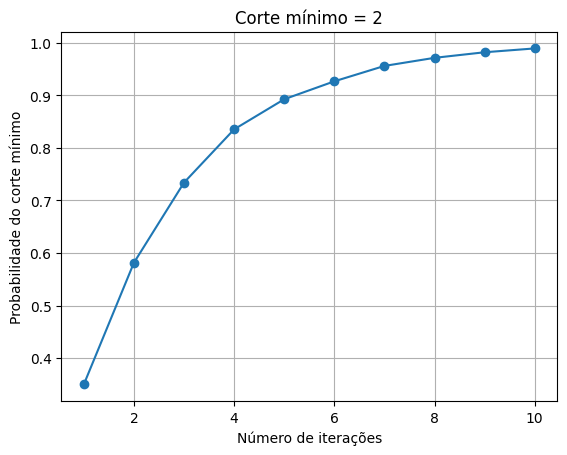

In [464]:

plt.plot(niteraction, probabilidade, marker='o',label='karger')
plt.xlabel('Número de iterações')
plt.ylabel('Probabilidade do corte mínimo')
plt.title(f'Corte mínimo = {minimo}')
plt.grid(True)
plt.legend()
plt.show()
